#### Code to train models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/Documents/kaggle_siim_covid/src


## Imports

In [3]:
import os
import cv2
import glob
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm
from matplotlib.patches import Rectangle

In [4]:
from params import *

In [5]:
from data.preparation import prepare_dataframe, handle_duplicates, add_additional_boxes
from data.dataset import CovidDetDataset, CovidClsDataset
from data.transforms import get_transfos_det, get_transfos_cls

from model_zoo.models import get_model
from model_zoo.encoders import get_encoder

from utils.plot import plot_sample
from utils.boxes import treat_boxes
from utils.logger import prepare_log_folder, save_config, create_logger, update_overall_logs

from training.main import k_fold

## Load

In [6]:
df = prepare_dataframe().copy()

In [7]:
clusts = np.load("../output/clusts.npy", allow_pickle=True)
found = np.load("../output/found.npy")
transpositions = np.load("../output/transpositions.npy", allow_pickle=True)

df = handle_duplicates(df, clusts, transpositions, plot=False)

In [8]:
df = add_additional_boxes(df)

# Look for leak

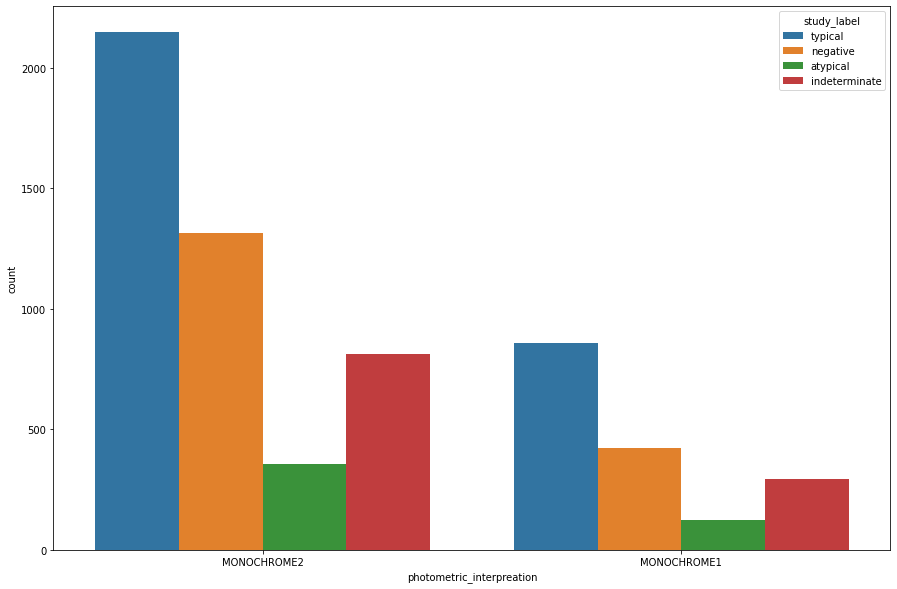

In [24]:
# for c in CLASSES:
plt.figure(figsize=(15, 10))
sns.countplot(x=df['photometric_interpreation'], hue=df["study_label"])
# plt.yscale('log')
plt.show()

## Missing boxes

In [ ]:
groups = df[['study_id', 'img_target']].groupby('study_id').mean()
groups = groups[groups['img_target'] > 0]
groups = groups[groups['img_target'] < 1]
# groups = groups[groups['img_target'] != 0.5]

In [ ]:
df_dup = df[df['study_id'].isin(groups.index)].reset_index(drop=True).sort_values('study_id').copy()

In [ ]:
from data.extraction import read_xray

for study in tqdm(df_dup['study_id'].unique()):
    print('-' * 60)
    print(f'Study {study}')
    
    df_study = df_dup[df_dup['study_id'] == study].copy().reset_index(drop=True)

    for i in range(len(df_study)):
        study = df_study['study_id'][i]
        image = df_study['image_id'][i].split('_')[0]

        study_path = os.path.join(DCM_PATH, "train", study)
        series = os.listdir(study_path)

        found = False
        for s in series:
            img_path = os.path.join(study_path, s, image + ".dcm")
            if os.path.exists(img_path):
                found = True
                break

        if not found:
            print(f'Image {i} not found')
            continue

        img, meta = read_xray(img_path)
        img = (img - img.min()) /  (img.max() - img.min())
        img = (img * 255).astype(np.uint8)
        boxes = np.array(df_study['boxes'][i]).astype(int)

        if len(boxes):
            print(f'Study {study}')
            print(f'Image {image}')
            print(f'Date {meta[(0x08, 0x20)].value}')
            print(boxes)
        
            plt.figure(figsize=(9, 9))
            plot_sample(img[:, :, None], boxes, bbox_format="coco", axis=True)
            plt.show()
        else:
            save_name = f"{study}_{image}.png"
            cv2.imwrite("../output/missing_boxes/" + save_name, img)

### Dataset

In [ ]:
plt.figure(figsize=(15, 5))
sns.countplot(x="label", hue="study_label", data=df)
plt.show()

plt.figure(figsize=(15, 5))
sns.countplot(x="study_label", hue="label", data=df)
plt.show()

In [ ]:
df_ = df[df['boxes'].apply(lambda x: len(x) > 0)].copy()

df_['w'] = df_['boxes'].apply(lambda x: np.array(x)[:, 2].mean() if len(x) else 0)
df_['h'] = df_['boxes'].apply(lambda x: np.array(x)[:, 2].mean() if len(x) else 0)

In [ ]:
plt.figure(figsize=(15, 5))
sns.boxplot(y="w", x="study_label", data=df_)
plt.show()

plt.figure(figsize=(15, 5))
sns.boxplot(y="h", x="study_label", data=df_)
plt.show()

In [ ]:
# transforms = get_transfos_det(augment=False, bbox_format="yolo")
# dataset = CovidDetDataset(df, DATA_PATH + f"train_{SIZE}/", bbox_format="yolo", transforms=transforms)

In [ ]:
df_l = df[df["study_label"] == "typical"].reset_index(drop=True)
dataset = CovidDetDataset(df_l, DATA_PATH + f"train_{SIZE}/", bbox_format="yolo")

In [ ]:
for i in np.random.choice(len(dataset), 10):
# for i in range(len(dataset)):
    img, mask, y, y_img, boxes = dataset[i]
    
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy().transpose(1, 2, 0)
        mask = mask.cpu().numpy()[:, :, None]

#     if len(boxes):
    plt.figure(figsize=(9, 9))
    plot_sample(img, boxes, bbox_format="yolo")
#         plot_sample(mask, boxes, bbox_format="yolo")
    plt.title(
        f'{df_l["save_name"][i][:-4]}  -  Study target : {CLASSES[int(y)]} - '
        f'Img target : {CLASSES_IMG[int(y_img)]}'
    )
    plt.show()


## Model

In [ ]:
# model = get_encoder('tf_efficientnet_b4_ns')

In [ ]:
model = get_model('tf_efficientnetv2_m_in21ft1k', reduce_stride=False, num_classes=4)

In [ ]:
transforms = get_transfos_cls(augment=False)
dataset = CovidClsDataset(df, DATA_PATH + f"train_{SIZE}/", transforms=transforms)

x, m, y, y_img = dataset[0]

plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.imshow(x.cpu().numpy().transpose(1, 2, 0))
plt.axis(False)
plt.subplot(1, 2, 2)
plt.imshow(m.cpu().numpy()[:, :, None])
plt.axis(False)

x = x.unsqueeze(0).float()
m = m.unsqueeze(0).float()
y = y.unsqueeze(0)
y_img = y_img.unsqueeze(0)

In [ ]:
pred = model(x)

In [ ]:
for p in pred:
    try:
        print(p.size())
    except:
        for p_ in p:
            print(' ', p_.size())

In [ ]:
from training.losses import CovidLoss
loss = CovidLoss()

In [ ]:
y, pred[0]

In [ ]:
loss = CovidLoss()
loss(pred[0], pred[1], pred[2], [y, y], y_img, m, 1)